### Group 16 - Yousef Kanj, Elias Antoun, Zhansaya Jumasheva, Ahmad Saad
# Traffic sign classification, Adversarial attacks, and Defense

With self driving cars becoming a popular topic in today's world, a lot of problems are required to be solved in order to make the idea a safe and reliable technology. One important task is to be able to see and classify traffic signs correctly for the safety of the passengers and pedestrians. Such a task can be classified as a computer vision task and traffic sign recognition can be solved very reliably using Convolutional Neural Networks.

 A malicious attack on our self driving car may target the data between the sensor and the network, and add small perturbations to the incoming data so that the CNN predicts it incorrectly. Such an attack, part of what we call Adversarial Attacks, is called the Fast Gradient Sign Method (FGSM). Essentially it takes the input data, and adds to it a very small coefficient multiplied by the sign of its gradient of the loss function, so that the original image looks unchanged. This would cause our model to return a wrong prediction.

 It is important for us to study how can we defend against these Adversarial Attacks, since this has real life applications for our safety. The dataset we will be using is the German Traffic Sign Recognition Benchmark (GTSRB) dataset. It has 62000 images of traffic signs classified into 43 classes.

 We will first train a CNN to recognize our dataset, we will then apply FGSM to our input images as part of our Adversarial Attack, and then we will try to defend against the FGSM method and see how well we did.




1. Import Necessary Libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



2. Define Functions for Loading and Preprocessing Data

In [2]:
# This function loads each image from its path and makes sure it is resized to it's correct size
def load_and_preprocess_image(image_path, img_size=(32, 32)):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # Here we normalize the pixels to [0,1]
        img = tf.image.resize(img, img_size)
        return img
    # A few images returned errors during reading which is why we added a Try Except statement.
    except tf.errors.NotFoundError:
        raise ValueError(f"Image not found or unable to load: {image_path}")

# This function loads the .csv files which contains the labels to each image path, so that we can associate each label to a loaded image
def load_dataset(dataset_path, csv_file, img_size=(32, 32)):
    df = pd.read_csv(csv_file)
    images = []
    labels = []
    for _, row in df.iterrows():
        image_path = os.path.join(dataset_path, row['Path'])
        images.append(load_and_preprocess_image(image_path, img_size))
        labels.append(row['ClassId'])
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

3. Load and Split the Dataset

In [3]:
TRAIN_PATH = r"C:\Users\youse\Desktop\FDS final"
TEST_PATH = r"C:\Users\youse\Desktop\FDS final"
TRAIN_CSV = r"C:\Users\youse\Desktop\FDS final\Test.csv"
TEST_CSV = r"C:\Users\youse\Desktop\FDS final\Test.csv"

train_images, train_labels = load_dataset(TRAIN_PATH, TRAIN_CSV)
test_images, test_labels = load_dataset(TEST_PATH, TEST_CSV)

# Split the training data into a training set and a validation set 
train_images, val_images, train_labels, val_labels = train_test_split(train_images.numpy(), train_labels.numpy(), test_size=0.2, random_state=42)

4. Build the CNN Model

Our CNN has an input layer that takes a 32x32 image with 3 color channels.  It then goes through the first convolutional layer of 32 3x3 filter kernels. These kernels use Rectified Linear Units for activation. The activation functions are essential and are what allow our neural network to work as a non-linear classifier. In our case our activation function is ReLU rakes the max{0,x}. It then goes to a Max-pooling layer which places a 2x2 kernel over the feature map and reduces its dimensions by taking the max value in that 2x2 window.

This feature map is then passed through convoluting layer twice more, with another Max-pooling layer in between them. These convolutions serve to recognize more complex features from our input. Finally the feature map is flattened into a 1D array, fed to a dense layer connected 1 to 1 to our flattened array. This dense layer is then connected to another dense 43 neurons, each corresponding to one of the unique classes we have.

We use the Adaptive Moment Estimation (ADAM) optimizer instead of stochastic gradient descent. Traditional stochastic gradient decent takes steps updating the parameters proportional to the magnitude of the gradient, this can lead to overshooting and going beyond the minima and takes long to converge. 

ADAM on the other hand keeps an exponentially decaying memory of the average of past gradients and of gradients squared (momentum and variance), this allows it to adjust learning rate for each parameter independently and converge much faster compared to SGD.

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(train_labels)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

5. Train the Model

You can notice that we used a train-validate-test split for our data, the validation split is used at each epoch for the model to try and predict. It is not part of the training set and no direct learning comes as a result of it. It helps tune the model hyper parameters for the next epoch and ensures that our model isn't overfitting. For example, if our model accuracy is high, but our validation accuracy is low, this would be good indicator of overfitting.

In [6]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10


316/316 [==============================] - 6s 13ms/step - loss: 2.3525 - accuracy: 0.3665 - val_loss: 1.1430 - val_accuracy: 0.6485
Epoch 2/10
316/316 [==============================] - 4s 13ms/step - loss: 0.6559 - accuracy: 0.8048 - val_loss: 0.3402 - val_accuracy: 0.8979
Epoch 3/10
316/316 [==============================] - 3s 10ms/step - loss: 0.2574 - accuracy: 0.9218 - val_loss: 0.1959 - val_accuracy: 0.9489
Epoch 4/10
316/316 [==============================] - 2s 8ms/step - loss: 0.1383 - accuracy: 0.9601 - val_loss: 0.1271 - val_accuracy: 0.9699
Epoch 5/10
316/316 [==============================] - 2s 7ms/step - loss: 0.0964 - accuracy: 0.9752 - val_loss: 0.1205 - val_accuracy: 0.9762
Epoch 6/10
316/316 [==============================] - 2s 7ms/step - loss: 0.0614 - accuracy: 0.9833 - val_loss: 0.1229 - val_accuracy: 0.9751
Epoch 7/10
316/316 [==============================] - 2s 7ms/step - loss: 0.0646 - accuracy: 0.9835 - val_loss: 0.1132 - val_accuracy: 0.9715
E

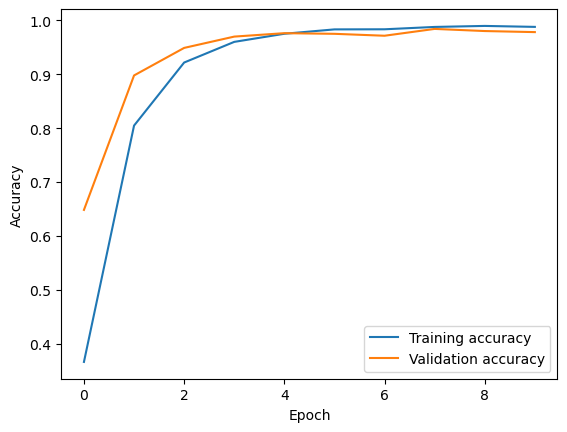

In [7]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Our model reached a 98.75% accuracy in 10 epochs with validation accuracy staying close to our model's accuracy. We can see above that overfitting should not be a concern as the model did quiet well on the validation sets.

Now we will visualize our misclassifications using a confusion matrix below.

395/395 [==============================] - 1s 3ms/step


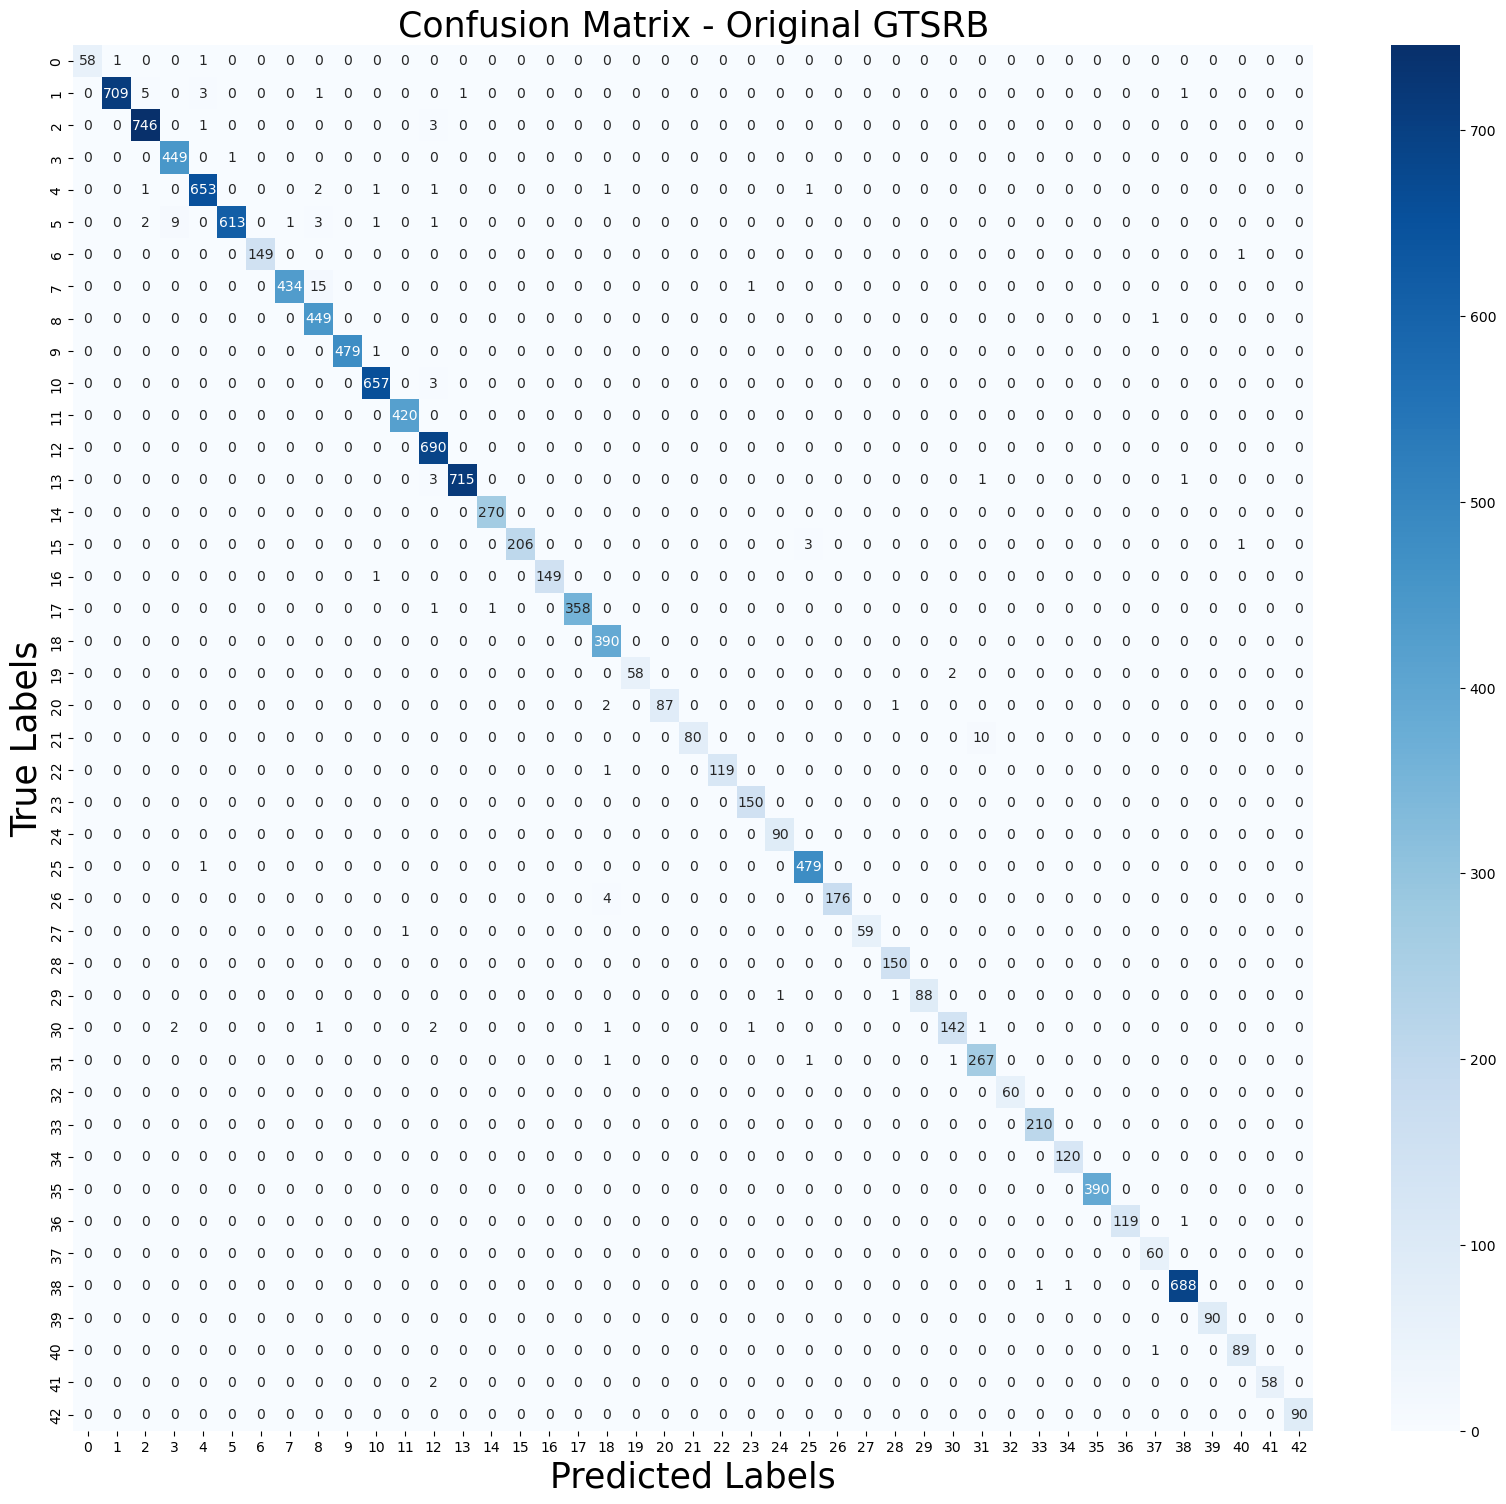

In [8]:
# Get predictions for the original test subset
original_predictions = model.predict(test_images)
original_predictions = np.argmax(original_predictions, axis=1)

# Get the Confusion matrix for the original test subset
conf_matrix_original = confusion_matrix(test_labels, original_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(conf_matrix_original, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 10})  # Increase font size for annotations
plt.title('Confusion Matrix - Original GTSRB', fontsize=25)
plt.xlabel('Predicted Labels', fontsize=25)
plt.ylabel('True Labels', fontsize=25)
plt.show()


6. Create Adversarial Examples Using FGSM

FSGM aims to change the input values of the image very slightly but not enough for it to be detectable by a human.

\begin{align}
\text{FGSM: \  } \  x = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y))
\end{align}

It takes the original image x, and adds to it a small value epsilon, multiplied by the sign of the gradient of the loss function. This helps increase the loss and turns the CNN away from classifying it correctly.

In [9]:
# This function returns the sign of our gradient of the loss function for a given image.
def create_adversarial_pattern(input_image, input_label, model):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

np.random.seed(0)
# We take a random 10000 images from our test subset and apply our FGSM attack
random_indices = tf.constant(np.random.choice(test_images.shape[0], 10000, replace=False))

test_subset = tf.gather(test_images, random_indices)
test_labels_subset = tf.gather(test_labels, random_indices)

# Create adversarial images
epsilon = 0.025
perturbations = create_adversarial_pattern(test_subset, test_labels_subset, model)
adversarial_test_images = test_subset + perturbations * epsilon


7. Visualize Some Original and Adversarial Images

A successful FGSM attack should be undetectable by the naked eye in order for the attack to remain unnoticed for as long as possible.

Below we can visualize some examples of our text images with after our FGSM attack. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


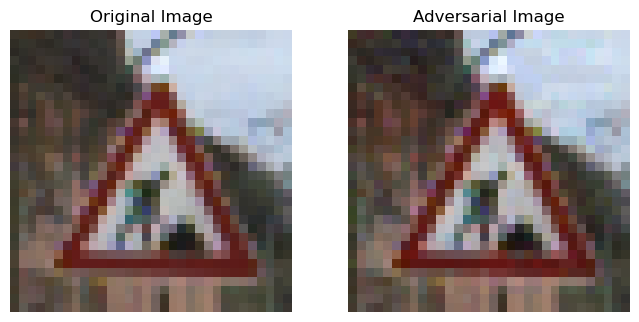

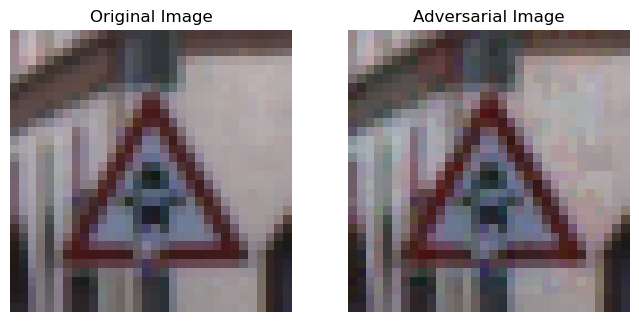

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


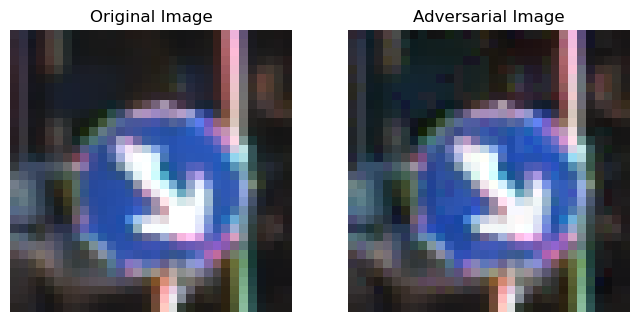

In [26]:
def display_image_pair(original_image, adversarial_image, title1, title2):
    plt.figure(figsize=(8, 5))
    
    # Display original image
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(original_image[0])
    plt.title(title1)
    plt.axis('off')

    # Display adversarial image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(adversarial_image[0])
    plt.title(title2)
    plt.axis('off')  
    plt.show()

for i in range(3):
    display_image_pair(test_subset[i:i+1], adversarial_test_images[i:i+1], "Original Image", "Adversarial Image")

As you can see the difference between the images before and after is unnoticeable. Lets see how much of an effect this can have on our CNN.

8. Evaluate Model Performance on Original and Adversarial Images

We now have the model test our images after FGSM was applied to them.

313/313 [==============================] - 1s 3ms/step - loss: 0.0369 - accuracy: 0.9909
Original Model Accuracy: 99.09%
313/313 [==============================] - 1s 3ms/step - loss: 8.4944 - accuracy: 0.3188
Adversarial Model Accuracy: 31.88%


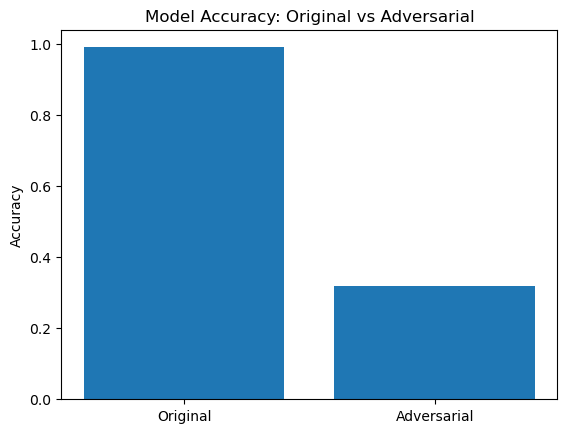

In [11]:
# Original test subset
loss, accuracy_before = model.evaluate(test_subset, test_labels_subset)
print("Original Model Accuracy: {:.2f}%".format(accuracy_before * 100))

# Adversarial test subset
loss, adversarial_accuracy_before = model.evaluate(adversarial_test_images, test_labels_subset)
print("Adversarial Model Accuracy: {:.2f}%".format(adversarial_accuracy_before * 100))

# Plotting comparison
plt.bar(['Original', 'Adversarial'], [accuracy_before, adversarial_accuracy_before])
plt.ylabel('Accuracy')
plt.title('Model Accuracy: Original vs Adversarial')
plt.show()


We can see that the same CNN scored 30% accuracy after an FGSM attack on the same dataset which it previously scored ~99% on.

Let's try and visualize this with a confusion matrix.

313/313 [==============================] - 1s 3ms/step


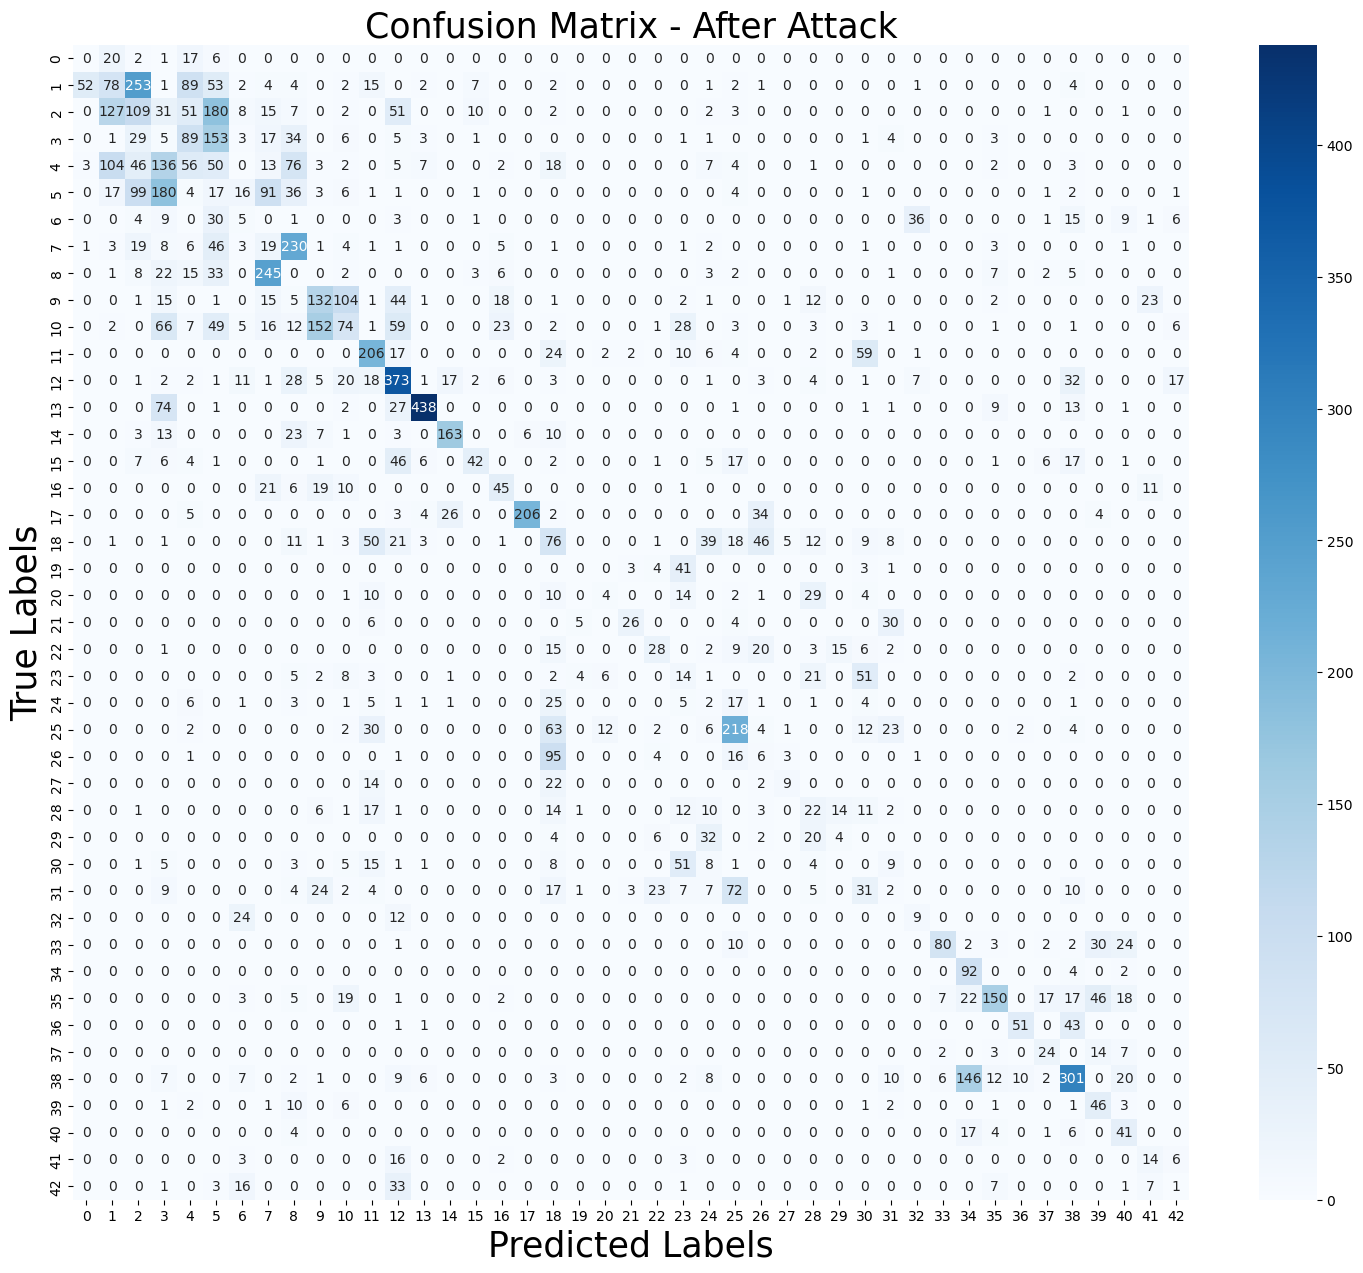

In [29]:
original_predictions = model.predict(adversarial_test_images)
original_predictions = np.argmax(original_predictions, axis=1)

conf_matrix_original = confusion_matrix(test_labels_subset, original_predictions)

plt.figure(figsize=(18,15))
sns.heatmap(conf_matrix_original, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 10})  # Increase font size for annotations
plt.title('Confusion Matrix - After Attack', fontsize=25)
plt.xlabel('Predicted Labels', fontsize=25)
plt.ylabel('True Labels', fontsize=25)
plt.show()


**DEFENSE**

Our goal now is to defend our CNN against future FGSM attacks and see how well we can do so. Assuming that we aim to defend against an FGSM attack but we do not know the specific epsilon used, we will train a cloned model on a large dataset composed of the original training set and on a FGSM attacked training set that we will create ourselves using a modest value of epsilon.

1. Generate Adversarial Training Set

In [13]:
# Convert inputs to tensors
train_subset_tensor = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels_subset_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int64)

# Train with a slightly higher epsilon for more intense but not entirely different perturbations
epsilon = 0.05

# Use the same function that was used before to generate new adversarial data to train the model on
train_perturbations = create_adversarial_pattern(train_subset_tensor, train_labels_subset_tensor, model)
adversarial_train_images = train_subset_tensor + train_perturbations * epsilon



2. Retrain the Model with the Adversarial Training Set

Note that in this step it is important to retrain the model with both the original (unaltered) and the new perturbed images.

In [14]:
# Clone the original model
model_adversarial_trained = tf.keras.models.clone_model(model)
model_adversarial_trained.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_adversarial_trained.set_weights(model.get_weights())

In [16]:
# Concatenate the training images and labels into one large training set
combined_train_images = np.concatenate([train_images, adversarial_train_images])
combined_train_labels = np.concatenate([train_labels, train_labels_subset_tensor.numpy()])

combined_train_images, val_images, combined_train_labels, val_labels = train_test_split(combined_train_images, combined_train_labels, test_size=0.2, random_state=42)

# Retrain the model
history_adversarial = model_adversarial_trained.fit(
    combined_train_images, 
    combined_train_labels, 
    epochs=10, 
    validation_data=(val_images, val_labels)
)

Epoch 1/10
506/506 [==============================] - 5s 8ms/step - loss: 0.9687 - accuracy: 0.7523 - val_loss: 0.3841 - val_accuracy: 0.8894
Epoch 2/10
506/506 [==============================] - 4s 8ms/step - loss: 0.2302 - accuracy: 0.9325 - val_loss: 0.2029 - val_accuracy: 0.9394
Epoch 3/10
506/506 [==============================] - 4s 7ms/step - loss: 0.1007 - accuracy: 0.9714 - val_loss: 0.1222 - val_accuracy: 0.9668
Epoch 4/10
506/506 [==============================] - 4s 8ms/step - loss: 0.0589 - accuracy: 0.9827 - val_loss: 0.1166 - val_accuracy: 0.9661
Epoch 5/10
506/506 [==============================] - 4s 7ms/step - loss: 0.0383 - accuracy: 0.9887 - val_loss: 0.1810 - val_accuracy: 0.9505
Epoch 6/10
506/506 [==============================] - 4s 8ms/step - loss: 0.0430 - accuracy: 0.9868 - val_loss: 0.0872 - val_accuracy: 0.9733
Epoch 7/10
506/506 [==============================] - 4s 8ms/step - loss: 0.0181 - accuracy: 0.9951 - val_loss: 0.1098 - val_accuracy: 0.9698
Epoch 

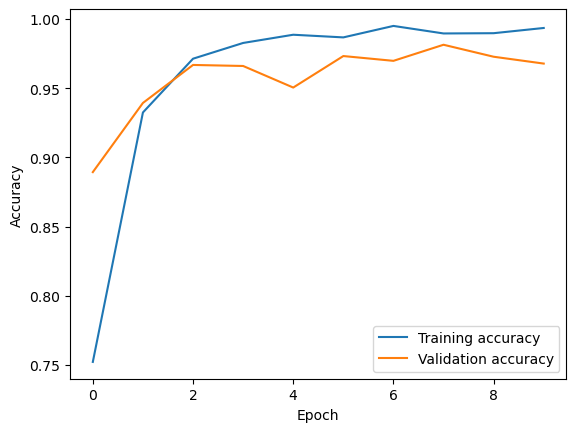

In [17]:
# Plot the accuracy against epochs
plt.plot(history_adversarial.history['accuracy'], label='Training accuracy')
plt.plot(history_adversarial.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

3. Evaluate the Model Performance After Adversarial Training

In [18]:
# Evaluate on original test subset
loss, accuracy = model_adversarial_trained.evaluate(test_subset, test_labels_subset)
print("Adversarially Trained Model Accuracy on Original Images: {:.2f}%".format(accuracy * 100))

# Evaluate on adversarial test subset
loss, adversarial_accuracy = model_adversarial_trained.evaluate(adversarial_test_images, test_labels_subset)
print("Adversarially Trained Model Accuracy on Adversarial Images: {:.2f}%".format(adversarial_accuracy * 100))



313/313 [==============================] - 1s 3ms/step - loss: 0.0671 - accuracy: 0.9841
Adversarially Trained Model Accuracy on Original Images: 98.41%
313/313 [==============================] - 1s 3ms/step - loss: 0.0637 - accuracy: 0.9847
Adversarially Trained Model Accuracy on Adversarial Images: 98.47%


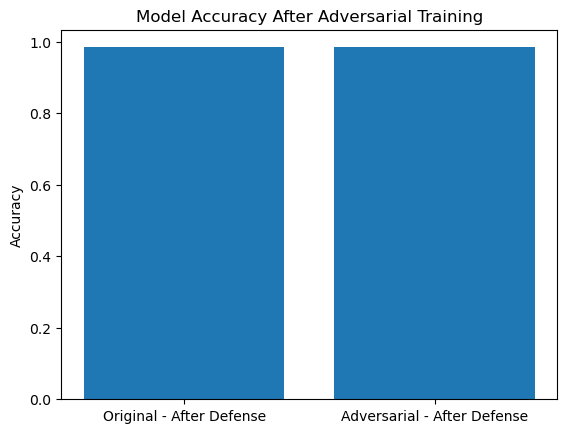

In [19]:
# Plotting comparison
plt.bar(['Original - After Defense', 'Adversarial - After Defense'], [accuracy, adversarial_accuracy])
plt.ylabel('Accuracy')
plt.title('Model Accuracy After Adversarial Training')
plt.show()

313/313 [==============================] - 1s 3ms/step


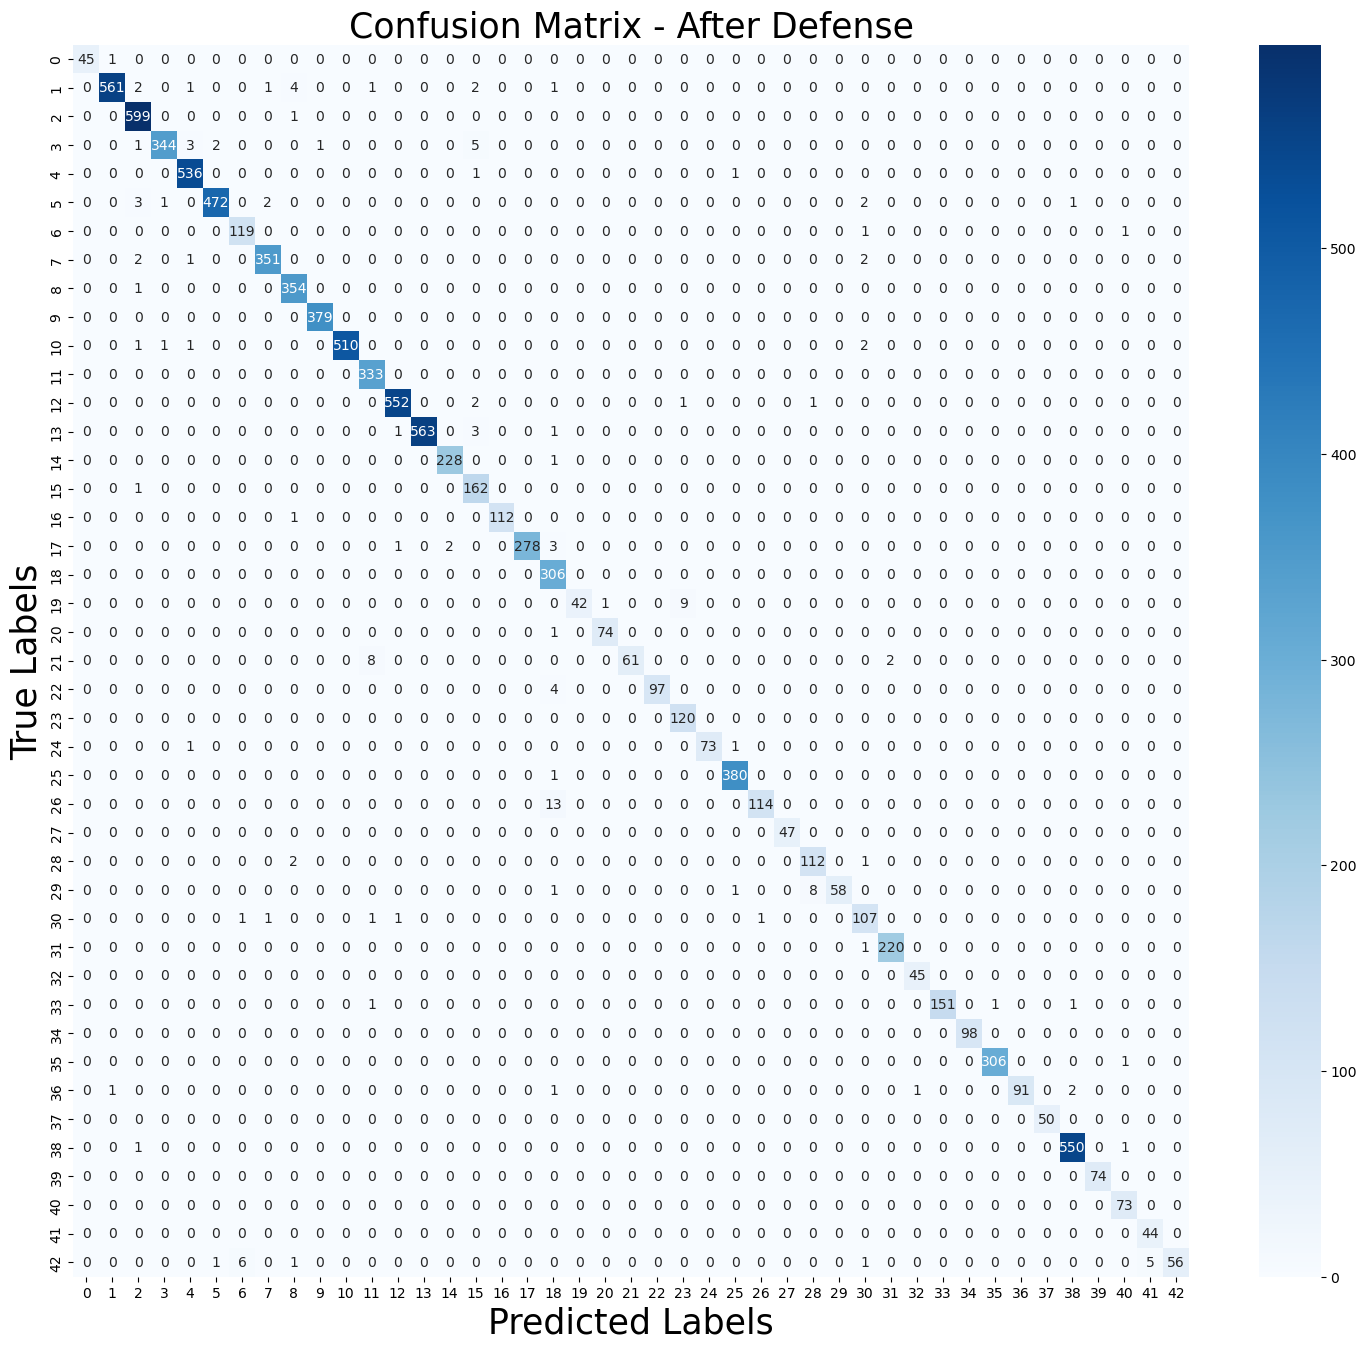

In [22]:
original_predictions = model_adversarial_trained.predict(adversarial_test_images)
original_predictions = np.argmax(original_predictions, axis=1)

conf_matrix_original = confusion_matrix(test_labels_subset, original_predictions)

plt.figure(figsize=(18, 16))
sns.heatmap(conf_matrix_original, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 10})  # Increase font size for annotations
plt.title('Confusion Matrix - After Defense', fontsize=25)
plt.xlabel('Predicted Labels', fontsize=25)
plt.ylabel('True Labels', fontsize=25)
plt.show()


4. Visualize the Effectiveness of the Defense Strategy

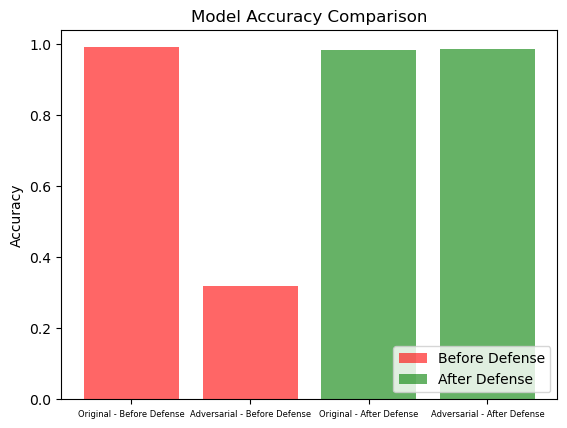

In [21]:
# Before Adversarial Training
plt.bar(['Original - Before Defense', 'Adversarial - Before Defense'], [accuracy_before, adversarial_accuracy_before], alpha=0.6, color='red')

# After Adversarial Training
plt.bar(['Original - After Defense', 'Adversarial - After Defense'], [accuracy, adversarial_accuracy], alpha=0.6, color='green')

plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend(['Before Defense', 'After Defense'], loc='lower right')
plt.xticks(fontsize=6)
plt.show()


#### Conclusions

We were able to train a CNN to classify our Traffic sign dataset with very high accuracy, but it was also very susceptible to attacks. Our attempt at an FGSM attack was very successful and the results are undetectable to the naked eye such that without knowing beforehand what the attack is, it would have been difficult to figure out what was happening with our CNN. As for our defense, after augmenting our training data with a with examples of attacked images and training an identical CNN, our CNN was able to achieve nearly equal accuracies on both the original test set and the attacked test set. While this was a great defense, in real life application we often would not know how our model might be attacked so this defense technique is not very robust.

#### References:

- Churilla, M., VanHoudnos, N., & Beveridge, R. (2023, May 15). The Challenge of Adversarial Machine Learning. Retrieved December 15, 2023, from https://doi.org/10.58012/jrjp-n210.

- Pavlitska, S., Lambing, N., & Zöllner, J. M. (2023). Adversarial attacks on traffic sign recognition: A survey. In Proceedings of the International Conference on Electrical, Computer, Communications and Mechatronics Engineering (ICECCME 2023)

- Stallkamp, J., Schlipsing, M., Salmen, J., & Igel, C. (2012). Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition. Neural Networks, https://doi.org/10.1016/j.neunet.2012.02.016
